# Udacity Deep Learning Project - Digit Recognition - Part 3 - Digit Localizer Evaluation

Author: Lei Mao <br>
Late revised on: 2/10/2016 <br>

### Import libraries required

In [31]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
from six.moves import cPickle as pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [32]:
%autosave 0

Autosave disabled


### Preprocess test dataset

In [33]:
# Read test dataset
SVHN_folder = 'data/SVHN_BB/'
pickle_file = 'test_set.pickle'

with open(SVHN_folder + pickle_file, 'rb') as f:
    print('Loading data ...')
    print('This may consume a lot of memories.')
    save = pickle.load(f)
    SVHN_test_dataset = save['dataset']
    SVHN_test_labels = save['labels']
    del save  # hint to help gc free up memory
    print('SVHN test set', SVHN_test_dataset.shape, SVHN_test_labels.shape)

Loading data ...
This may consume a lot of memories.
('SVHN test set', (13068, 48, 48, 3), (13068, 4))


In [34]:
# Split test dataset to test and validation datasets
SVHN_test_dataset, SVHN_valid_dataset, SVHN_test_labels, SVHN_valid_labels = train_test_split(
    SVHN_test_dataset, SVHN_test_labels, test_size = 5./10, random_state = 0)

In [35]:
# Check the size of each dataset
print('Test set: %d images and %d labels.' %(len(SVHN_test_dataset), len(SVHN_test_labels)))

Test set: 6534 images and 6534 labels.


In [36]:
def image_norm(dataset):
    dataset_copy = dataset.astype(np.int32)
    dataset_norm = np.zeros(shape = (dataset.shape[0], dataset.shape[1], dataset.shape[2], dataset.shape[3]), dtype = np.uint8)
    for i in xrange(len(dataset_copy)):
        dataset_norm[i] = dataset_copy[i] - np.average(dataset_copy[i])
    return dataset_norm

In [37]:
test_dataset = image_norm(SVHN_test_dataset)
test_labels = SVHN_test_labels

In [38]:
def bbox_show(img, bbox_label):
    '''bbox_label: [topleft_x, topleft_y, bottomright_x, bottomright_y]'''
    img_data = img.copy()
    cv2.rectangle(img_data, (bbox_label[0], bbox_label[1]), (bbox_label[2], bbox_label[3]), (0,255,0), 1)
    fig = plt.figure()
    plotwindow = fig.add_subplot(111)
    plt.imshow(img_data)
    plt.show()
    return

In [39]:
def bbox_compare(img, bbox_label, bbox_prediction):
    '''bbox_label: [topleft_x, topleft_y, bottomright_x, bottomright_y]'''
    img_data = img.copy()
    cv2.rectangle(img_data, (bbox_label[0], bbox_label[1]), (bbox_label[2], bbox_label[3]), (0,255,0), 1)
    cv2.rectangle(img_data, (bbox_prediction[0], bbox_prediction[1]), (bbox_prediction[2], bbox_prediction[3]), (255,0,0), 1)
    fig = plt.figure()
    plotwindow = fig.add_subplot(111)
    plt.imshow(img_data)
    plt.show()
    return

### Define IoU evaluation function

In [40]:
def union(r1, r2):
    '''Minimal rectangle covering two rectangles.
    Python OpenCV rectangle format: [topleft_x, topleft_y, bottomright_x, bottomright_y]'''
    topleft_x = min(r1[0], r2[0])
    topleft_y = min(r1[1], r2[1])
    bottomright_x = max(r1[2], r2[2])
    bottomright_y = max(r1[3], r2[3])
    return (topleft_x, topleft_y, bottomright_x, bottomright_y)

def intersection(r1, r2):
    '''Intersection of two rectangles.
    Python OpenCV rectangle format: [topleft_x, topleft_y, bottomright_x, bottomright_y]'''
    topleft_x = max(r1[0], r2[0])
    topleft_y = max(r1[1], r2[1])
    bottomright_x = min(r1[2], r2[2])
    bottomright_y = min(r1[3], r2[3])
    if (bottomright_x - topleft_x < 0) or (bottomright_y - bottomright_x < 0): 
        return (0, 0, 0, 0) # or ()
    else:
        return (topleft_x, topleft_y, bottomright_x, bottomright_y)
    
def IoU_calculation(r1, r2):
    '''Calculate the IoU between two OpenCV rectangles.
    It seems that, unlike C++, OpenCV python does not have rectangle object,
    which means I might not be able to use the library union and intersection as in C++.
    Python OpenCV rectangle format: [topleft_x, topleft_y, bottomright_x, bottomright_y]'''
    r3 = intersection(r1, r2)
    intersection_area = (r3[2] - r3[0]) * (r3[3] - r3[1])
    union_area = (r1[2] - r1[0]) * (r1[3] - r1[1]) + (r2[2] - r2[0]) * (r2[3] - r2[1]) - intersection_area
    
    # To prevent division 0
    if union_area <= 0:
        return 0
    
    IoU = float(intersection_area) / union_area
    return IoU

### Restore model

In [41]:
batch_size = 64
patch_size = 3
depth_1 = 16
depth_2 = 32
depth_3 = 64

num_hidden = 64
keep_prob = 0.8

num_image_rows = 48
num_image_columns = 48
num_channels = 3
num_labels = 4

L2_beta = 0.01


graph = tf.Graph()

with graph.as_default():
    
    # Input data
    tf_regressor_weights = tf.constant([0.25, 0.25, 0.25, 0.25], dtype=tf.float32)

    # Variables
    cnn_1_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth_1], stddev=0.1), 
                                name = 'CNN_1_1_W')
    cnn_1_1_biases = tf.Variable(tf.zeros([depth_1]), name = 'CNN_1_1_B')

    cnn_1_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_1, depth_1], stddev=0.1), 
                                name = 'CNN_1_2_W')
    cnn_1_2_biases = tf.Variable(tf.zeros([depth_1]), name = 'CNN_1_2_B')    

    cnn_2_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_1, depth_2], stddev=0.1), 
                                name = 'CNN_2_1_W')
    cnn_2_1_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]), name = 'CNN_2_1_B')

    cnn_2_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_2, depth_2], stddev=0.1), 
                                name = 'CNN_2_2_W')
    cnn_2_2_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]), name = 'CNN_2_2_B')

    cnn_3_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_2, depth_3], stddev=0.1), 
                                name = 'CNN_3_1_W')
    cnn_3_1_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]), name = 'CNN_3_1_B')

    cnn_3_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_3, depth_3], stddev=0.1), 
                                name = 'CNN_3_2_W')
    cnn_3_2_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]), name = 'CNN_3_2_B')

    fc_1_weights = tf.Variable(tf.truncated_normal(
            [num_image_rows // 8 * num_image_columns // 8 * depth_3, num_hidden], stddev=0.1), name = 'FC_1_W')
    fc_1_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name = 'FC_1_B')
    
    logistic_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1), name = 'H_W')
    logistic_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name = 'H_B')
    
    # Model
    def model(data, keep_prob = keep_prob):
        
        conv = tf.nn.conv2d(data, cnn_1_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_1_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_1_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_1_2_biases)        
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
        
        conv = tf.nn.conv2d(hidden, cnn_2_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_2_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_2_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_2_2_biases)
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        conv = tf.nn.conv2d(hidden, cnn_3_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_3_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_3_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_3_2_biases)
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
        hidden = tf.nn.dropout(hidden, keep_prob = keep_prob)
        
        logits = tf.matmul(hidden, logistic_weights) + logistic_biases
        
        return logits
    
    # Prediction of single test data
    # Input data
    tf_test_single = tf.placeholder(tf.float32, shape=(1, num_image_rows, num_image_columns, num_channels))
    # Predict the logits in single test data
    test_logits_single = model(tf_test_single, keep_prob = 1.0) 
    
    saver = tf.train.Saver()

### SVHN examples

In [42]:
# Choose 5 random examples from test dataset
np.random.seed(3)
num_examples = 5

In [43]:
model_path = 'model/'
dataset = test_dataset
index = np.random.randint(len(dataset), size = num_examples)
predicted_labels = list()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    saver.restore(session, model_path + 'CNN_SVHN_BB')
    for i in xrange(num_examples):
        img = dataset[[index[i]]]
        feed_dict = {tf_test_single: img}
        prediction_array = test_logits_single.eval(feed_dict = feed_dict)[0]
        predicted_labels.append(prediction_array)

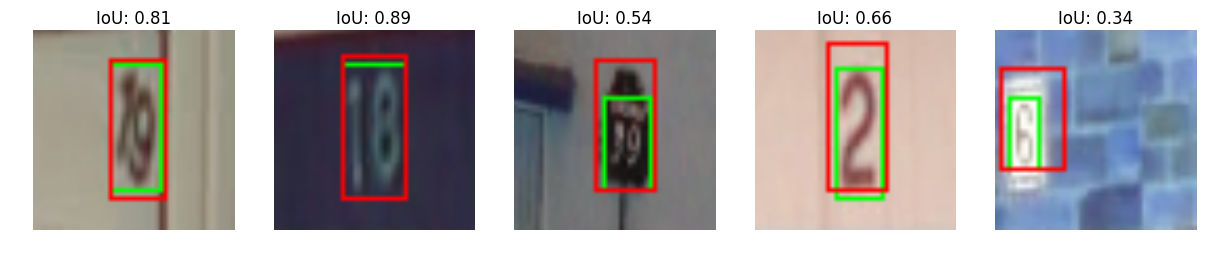

In [44]:
fig, axes = plt.subplots(nrows = 1, ncols = num_examples, figsize = (15, 5))
for i in xrange(num_examples):
    img_data = SVHN_test_dataset[index[i]]
    bbox_label = test_labels[index[i]]
    bbox_prediction = predicted_labels[i]
    cv2.rectangle(img_data, (bbox_label[0], bbox_label[1]), (bbox_label[2], bbox_label[3]), (0,255,0), 1)
    cv2.rectangle(img_data, (bbox_prediction[0], bbox_prediction[1]), (bbox_prediction[2], bbox_prediction[3]), (255,0,0), 1)
    IoU = round(IoU_calculation(r1 = bbox_prediction, r2 = bbox_label), 2)
    
    axes[i].axis('off')
    axes[i].imshow(img_data)
    axes[i].set_title('IoU: ' + str(IoU), loc='center')

report_folder = 'report/'
if not os.path.exists(report_folder):
    os.makedirs(report_folder)
fig.savefig(report_folder + 'SVHN_bbox_prediction.jpeg', format = 'jpeg', dpi = 300, bbox_inches = 'tight')

It seems that the bounding box localizer works well on the SVHN dataset. It should be noted that the green box is the bounding box labeled and the red box is the bounding box predicted. IoU stands for 'Intersection over Union'. It is an value between 0 and 1, and an evaluation of the bounding box prediction.

### Real examples

In [45]:
test_folder = 'test/real/'
file_names = os.listdir(test_folder)
real_dataset = np.zeros(shape = (len(file_names), num_image_rows, num_image_columns, 3), dtype = np.uint8)
for i, file_name in enumerate(file_names):
    img = cv2.imread(test_folder + file_name)
    img_resized = cv2.resize(img, (num_image_rows, num_image_columns))
    real_dataset[i] = img_resized

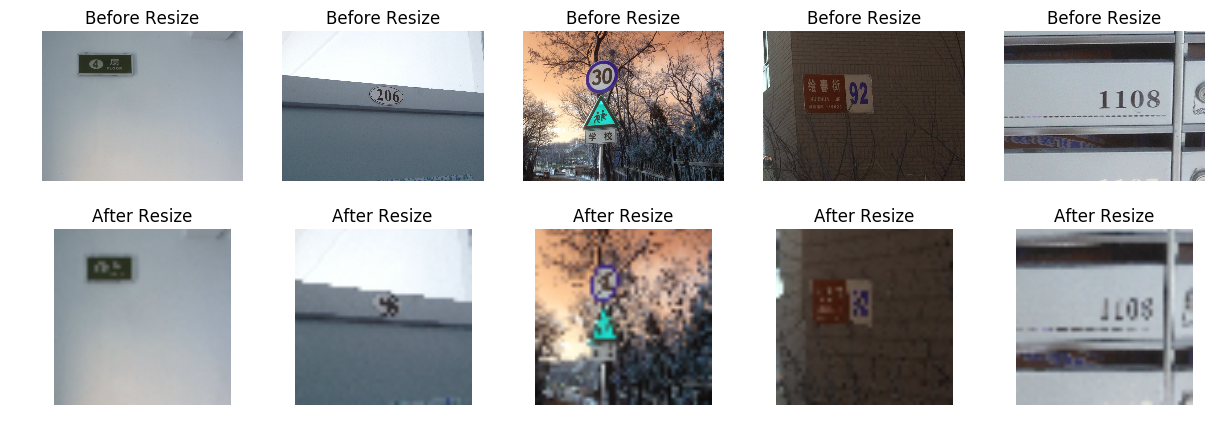

In [46]:
fig, axes = plt.subplots(nrows = 2, ncols = num_examples, figsize = (15, 5))
for i in xrange(num_examples):
    axes[0, i].axis('off')
    axes[0, i].imshow(cv2.imread(test_folder + file_names[i]))
    axes[0, i].set_title('Before Resize', loc='center')
    
    axes[1, i].axis('off')
    axes[1, i].imshow(real_dataset[i])
    axes[1, i].set_title('After Resize', loc='center')
    
report_folder = 'report/'
if not os.path.exists(report_folder):
    os.makedirs(report_folder)
fig.savefig(report_folder + 'real_image_samples.jpeg', format = 'jpeg', dpi = 300, bbox_inches = 'tight')

In [47]:
real_dataset_norm = image_norm(real_dataset)

In [48]:
model_path = 'model/'
dataset = real_dataset_norm
predicted_labels = list()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    saver.restore(session, model_path + 'CNN_SVHN_BB')
    for i in xrange(num_examples):
        img = dataset[[i]]
        feed_dict = {tf_test_single: img}
        prediction_array = test_logits_single.eval(feed_dict = feed_dict)[0]
        predicted_labels.append(prediction_array)

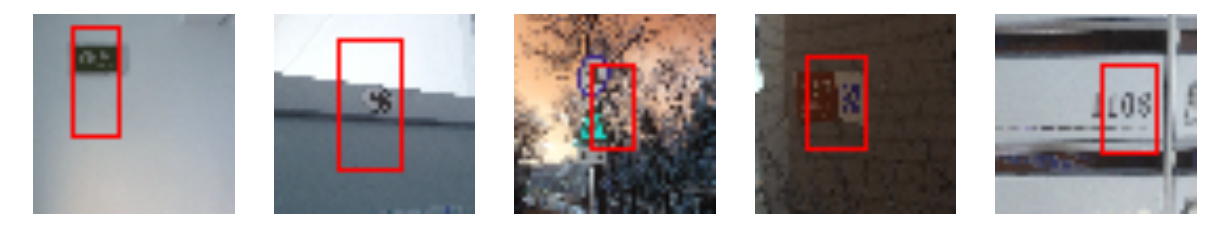

In [49]:
fig, axes = plt.subplots(nrows = 1, ncols = num_examples, figsize = (15, 5))
for i in xrange(num_examples):
    img_data = real_dataset[i]
    bbox_prediction = predicted_labels[i]
    cv2.rectangle(img_data, (bbox_prediction[0], bbox_prediction[1]), (bbox_prediction[2], bbox_prediction[3]), (255,0,0), 1)
    
    axes[i].axis('off')
    axes[i].imshow(img_data)

report_folder = 'report/'
if not os.path.exists(report_folder):
    os.makedirs(report_folder)
fig.savefig(report_folder + 'real_image_resized_bbox_prediction.jpeg', format = 'jpeg', dpi = 300, bbox_inches = 'tight')

In [50]:
def bbox_recover(img, bbox_label, size):
    '''This is a function to calculate the bounding box after image size recovery.
    img: np.ndarry of img
    bbox_label: [topleft_x, topleft_y, bottomright_x, bottomright_y]
    size: size of image after resize'''
    multiplier = np.array([float(img.shape[1])/size, float(img.shape[0])/size, float(img.shape[1])/size, float(img.shape[0])/size])
    
    topleft_x_recovered = np.floor(bbox_label[0] * multiplier[0])
    topleft_y_recovered = np.floor(bbox_label[1] * multiplier[1])
    bottomright_x_recovered = np.ceil(bbox_label[2] * multiplier[2])
    bottomright_y_recovered = np.ceil(bbox_label[3] * multiplier[3])
    
    bbox_label_recovered = np.int32([topleft_x_recovered, topleft_y_recovered, bottomright_x_recovered, bottomright_y_recovered])
    return bbox_label_recovered

In [51]:
# Recover the predicted bounding box parameters to match its original raw image
size = num_image_rows
predicted_labels_recovered = list()
for i in xrange(num_examples):
    img = cv2.imread(test_folder + file_names[i])
    predicted_labels_recovered.append(bbox_recover(img, predicted_labels[i], size))

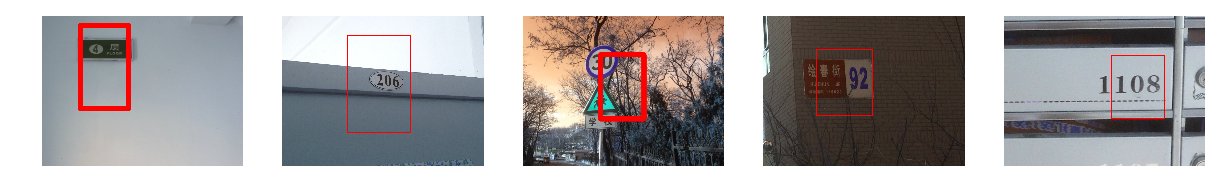

In [52]:
fig, axes = plt.subplots(nrows = 1, ncols = num_examples, figsize = (15, 5))
for i in xrange(num_examples):
    img_data = cv2.imread(test_folder + file_names[i]).copy()
    bbox_prediction = predicted_labels_recovered[i]
    cv2.rectangle(img_data, (bbox_prediction[0], bbox_prediction[1]), (bbox_prediction[2], bbox_prediction[3]), (255,0,0), 15)
    
    axes[i].axis('off')
    axes[i].imshow(img_data)
    
report_folder = 'report/'
if not os.path.exists(report_folder):
    os.makedirs(report_folder)
fig.savefig(report_folder + 'real_image_bbox_prediction.jpeg', format = 'jpeg', dpi = 300, bbox_inches = 'tight')

### Connect digit localizer with digit recognizer

In [53]:
real_dataset_cropped = np.zeros(shape = (num_examples, 32, 32, 3), dtype = np.uint8)

for i in xrange(num_examples):
    img_data = cv2.imread(test_folder + file_names[i]).copy()
    bbox_prediction = predicted_labels_recovered[i]
    img_data_cropped = img_data[bbox_prediction[1]:bbox_prediction[3], bbox_prediction[0]:bbox_prediction[2]]
    img_data_cropped = cv2.resize(img_data_cropped, (32, 32))
    real_dataset_cropped[i] = img_data_cropped

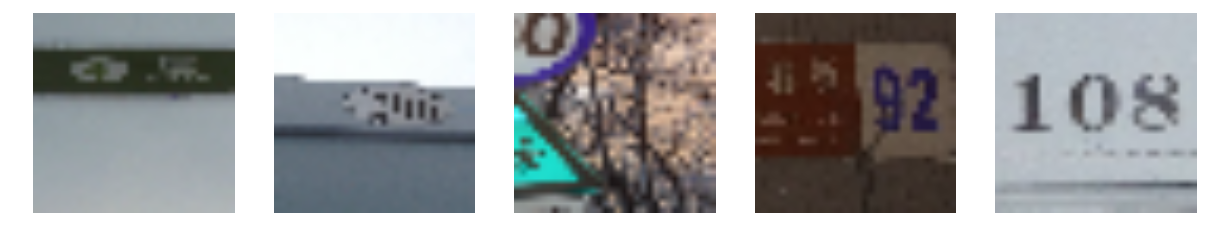

In [54]:
fig, axes = plt.subplots(nrows = 1, ncols = num_examples, figsize = (15, 5))
for i in xrange(num_examples):
    axes[i].axis('off')
    axes[i].imshow(real_dataset_cropped[i])

report_folder = 'report/'
if not os.path.exists(report_folder):
    os.makedirs(report_folder)
fig.savefig(report_folder + 'real_image_cropped.jpeg', format = 'jpeg', dpi = 300, bbox_inches = 'tight')

In [55]:
def image_grayed(dataset):
    dataset_grayed = np.zeros(shape = (dataset.shape[0], dataset.shape[1], dataset.shape[2], 1), dtype = np.int32)
    for i in xrange(len(dataset)):
        for j in xrange(dataset.shape[3]):
            dataset_grayed[i, :, :, 0] += dataset[i, :, :, j]
        dataset_grayed[i] = dataset_grayed[i] // dataset.shape[3]
        # Normalize each image by subtracting its mean
        dataset_grayed[i, :, :, 0] = dataset_grayed[i, :, :, 0] - np.mean(dataset_grayed[i, :, :, 0])
    return dataset_grayed.astype(np.uint8)

In [56]:
real_dataset_cropped_grayed = image_grayed(real_dataset_cropped)

In [57]:
batch_size = 64
patch_size = 3
depth_1 = 16
depth_2 = 32
depth_3 = 64

num_hidden = 64
num_channels = 1
keep_prob = 0.8

length_limit = 5
num_image_rows = 32
num_image_columns = 32
num_channels = 1

num_length_class = (length_limit + 2) # 0, 1, 2, 3, 4, 5, more than 5
num_digit_class = 11 # 0: blank, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 0

graph = tf.Graph()

with graph.as_default():

    # Variables
    cnn_1_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth_1], stddev=0.1), 
                                name = 'CNN_1_1_W')
    cnn_1_1_biases = tf.Variable(tf.zeros([depth_1]), name = 'CNN_1_1_B')

    cnn_1_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_1, depth_1], stddev=0.1), 
                                name = 'CNN_1_2_W')
    cnn_1_2_biases = tf.Variable(tf.zeros([depth_1]), name = 'CNN_1_2_B')    

    cnn_2_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_1, depth_2], stddev=0.1), 
                                name = 'CNN_2_1_W')
    cnn_2_1_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]), name = 'CNN_2_1_B')

    cnn_2_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_2, depth_2], stddev=0.1), 
                                name = 'CNN_2_2_W')
    cnn_2_2_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]), name = 'CNN_2_2_B')

    cnn_3_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_2, depth_3], stddev=0.1), 
                                name = 'CNN_3_1_W')
    cnn_3_1_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]), name = 'CNN_3_1_B')

    cnn_3_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_3, depth_3], stddev=0.1), 
                                name = 'CNN_3_2_W')
    cnn_3_2_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]), name = 'CNN_3_2_B')

    fc_1_weights = tf.Variable(tf.truncated_normal(
            [num_image_rows // 8 * num_image_columns // 8 * depth_3, num_hidden], stddev=0.1), name = 'FC_1_W')
    fc_1_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name = 'FC_1_B')
    
    logistic_weights = list()
    logistic_biases = list()
    logistic_weights.append(tf.Variable(tf.truncated_normal([num_hidden, num_length_class], stddev=0.1), name = 'H0_W'))
    logistic_biases.append(tf.Variable(tf.zeros([num_length_class]), name = 'H0_B'))
    
    for i in xrange(length_limit):
        logistic_weights.append(tf.Variable(
                tf.truncated_normal([num_hidden, num_digit_class], stddev=0.1), name = 'H' + str(i + 1) + '_W'))
        logistic_biases.append(tf.Variable(tf.constant(1.0, shape=[num_digit_class]), name = 'H' + str(i + 1) + '_B'))

    # Model
    def model(data, keep_prob = keep_prob):
        
        conv = tf.nn.conv2d(data, cnn_1_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_1_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_1_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_1_2_biases)        
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
        
        conv = tf.nn.conv2d(hidden, cnn_2_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_2_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_2_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_2_2_biases)
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        conv = tf.nn.conv2d(hidden, cnn_3_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_3_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_3_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_3_2_biases)
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
        hidden = tf.nn.dropout(hidden, keep_prob = keep_prob)
        
        logits = list()
        for i in xrange(length_limit + 1):
            logits.append(tf.matmul(hidden, logistic_weights[i]) + logistic_biases[i])
        
        return logits

    # Prediction of single test data
    # Input data
    tf_test_single = tf.placeholder(tf.float32, shape=(1, num_image_rows, num_image_columns, num_channels))
    # Predict the length of sequence in single test data
    test_logits_single = model(tf_test_single, keep_prob = 1.0)
    test_prediction_length_single = tf.nn.softmax(test_logits_single[0])
    # Predict the digits of sequence in single test data
    test_prediction_digits_single = list()
    for i in xrange(length_limit):
        test_prediction_digits_single.append(tf.nn.softmax(test_logits_single[i + 1]))
    test_prediction_digits_single = tf.pack(test_prediction_digits_single)

    saver = tf.train.Saver()

In [58]:
model_path = 'model/'
dataset = real_dataset_cropped_grayed
predicted_labels = list()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    saver.restore(session, model_path + 'CNN_SVHN')
    for i in xrange(num_examples):
        img = dataset[[i]]
        feed_dict = {tf_test_single: img}
        prediction_array = test_prediction_digits_single.eval(feed_dict = feed_dict)
        prediction_number = list()
        for j in xrange(len(prediction_array)):
            prediction_number.append(np.argmax(prediction_array[j]))
        predicted_labels.append(prediction_number)

In [59]:
def label_translation(label_array):
    translation_dict = {0: '', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '0'}
    label_translated = ''
    for i in xrange(len(label_array)):
        label_translated += translation_dict[label_array[i]]
    return label_translated

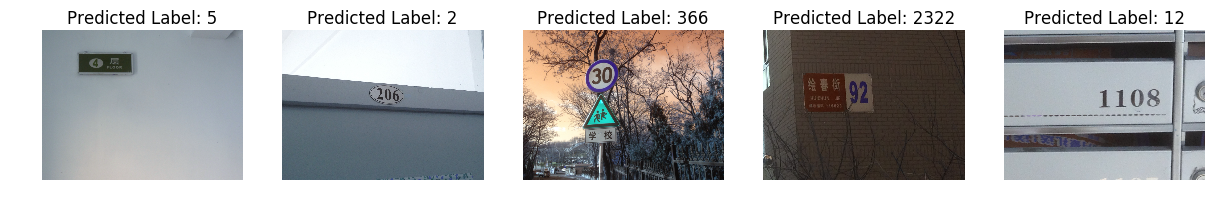

In [60]:
num_subplots = num_examples

fig, axes = plt.subplots(nrows = 1, ncols = num_examples, figsize = (15, 5))
for i in xrange(num_examples):
    axes[i].axis('off')
    axes[i].imshow(cv2.imread(test_folder + file_names[i]))
    axes[i].set_title('Predicted Label: ' + label_translation(predicted_labels[i]), loc='center')

report_folder = 'report/'
if not os.path.exists(report_folder):
    os.makedirs(report_folder)
fig.savefig(report_folder + 'real_image_cropped_prediction.jpeg', format = 'jpeg', dpi = 300, bbox_inches = 'tight')

The digit recognizer still did not get the prediction right. It is very likely due to that the digit localizer is not good enough to catch a digit sequence that is similar enough to the training data that the digit recognizer was trained on.